[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shashist/recsys-course/blob/master/week_03_matrix_factorization/rs_seminar_svd.ipynb)

In [1]:
from typing import Optional

import abc
import numpy as np
import math
import pandas as pd

from copy import deepcopy

from sklearn.preprocessing import LabelEncoder

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_path = 'drive/MyDrive/mts_lib_copy/'
log_name = 'interactions.csv'
u_features_name = 'users.csv'
i_features_name = 'items.csv'

In [4]:
SEED = 123
K=10

# RS datasets and SVD
- dataset EDA
- scipy sparse SVD
- personalized recommendations
- item2item recommendations

# Dataset

[MTS Library](https://www.kaggle.com/sharthz23/mts-library): book reading history for russian reading service.

### Preprocessing

In [5]:
df = pd.read_csv(data_path+log_name, sep=',')

In [6]:
assert df.shape[0] == 1533078

In [7]:
df.head(2)

,user_id,item_id,progress,rating,start_date
0,126706,14433,80,NaN,2018-01-01
1,127290,140952,58,NaN,2018-01-01


In [8]:
%%time
# конвертируем в дату
df.loc[:, 'start_date'] = pd.to_datetime(df['start_date'], format="%Y-%m-%d")
# удаляем дубликаты, оставляя последний по времени
df = df.sort_values('start_date').drop_duplicates(subset=['user_id', 'item_id'], keep='last')

u_features = pd.read_csv(data_path+u_features_name, sep=',')
i_features = pd.read_csv(data_path+i_features_name, sep=',')
i_features.rename(columns={'id': 'item_id'}, inplace=True)

<timed exec>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


CPU times: user 786 ms, sys: 120 ms, total: 906 ms
Wall time: 1.82 s


### Data

In [9]:
u_features.head(2)

,user_id,age,sex
0,1,45_54,NaN
1,2,18_24,0.0


In [10]:
%%time
i_features.head(2)

CPU times: user 118 µs, sys: 19 µs, total: 137 µs
Wall time: 140 µs


,item_id,title,genres,authors,year
0,128115,Ворон-челобитчик,"Зарубежные детские книги,Сказки,Зарубежная кла...",Михаил Салтыков-Щедрин,1886
1,210979,Скрипка Ротшильда,"Классическая проза,Литература 19 века,Русская ...",Антон Чехов,1894


In [11]:
i_features.shape, i_features['item_id'].isin(df['item_id'].unique()).shape

((59599, 5), (59599,))

In [12]:
def get_log_info(log, user_id='user_id', item_id='item_id'):
    print(f'Num interactions = {log.shape[0]},\nnum users = {log[user_id].nunique()},\nnum items = {log[item_id].nunique()}')

In [13]:
get_log_info(df)

Num interactions = 1532998,
num users = 151600,
num items = 59599


In [14]:
f"Num ratings = {(~df['rating'].isna()).sum()}, is much less than reading progress data ({(~df['progress'].isna()).sum()})"


'Num ratings = 285337, is much less than reading progress data (1532998)'

In [15]:
df.head(2)

,user_id,item_id,progress,rating,start_date
0,126706,14433,80,NaN,2018-01-01
1437,97128,245669,1,NaN,2018-01-01


## RS data features
- user/session and item ids are available
- interactions timestamp are often present
- user feedback is known (fact of features)

In [16]:
df['progress'].min(), df['progress'].max(), df['rating'].min(), df['rating'].max()

(0, 100, 1.0, 5.0)

## Feedback types

Progress and rating

**Explicit**
- less data available
- explicit opinions
- biased

**Implicit**
- lots of data
- heterogeneous
- difficult to distinguish positive and negative feedback
- fair preferences

## RS tasks

* top-k personalized recommendations
* reranking
* find similar item2user, item2item
* session-based, next basket, etc.

# EDA

#### Reading progress dist

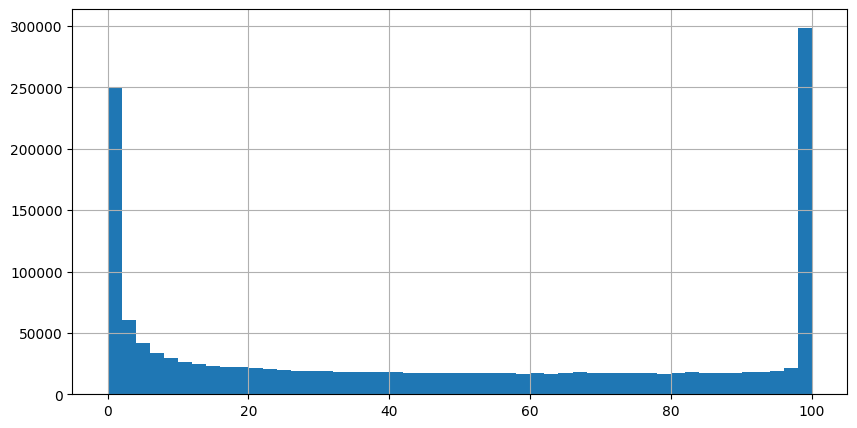

In [17]:
df['progress'].hist(bins=50, figsize=(10, 5));

#### Rating dist

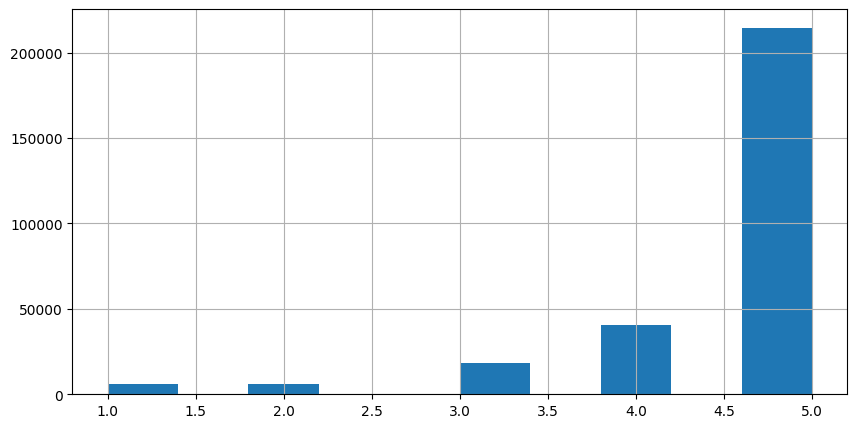

In [18]:
df['rating'].hist(bins=10, figsize=(10, 5));

In [19]:
df['rating'].value_counts()

5.0    214703
4.0     40382
3.0     18273
1.0      6115
2.0      5864
Name: rating, dtype: int64

#### Num interactions per user/item

In [20]:
def group_by_and_plot(df, group_by_name, rating_col_name, quantile=0.99, title=''):
    grouped = df.groupby(group_by_name)[rating_col_name].count()
    print(grouped.describe(percentiles=[0.05, .25, .5, .75, 0.95]))
    grouped[grouped < grouped.quantile(quantile)].plot(kind='hist', bins=50, figsize=(10, 5), title=title)
    return grouped

count    151600.000000
mean         10.112124
std          20.922963
min           1.000000
5%            3.000000
25%           5.000000
50%           7.000000
75%          10.000000
95%          20.000000
max        2091.000000
Name: progress, dtype: float64


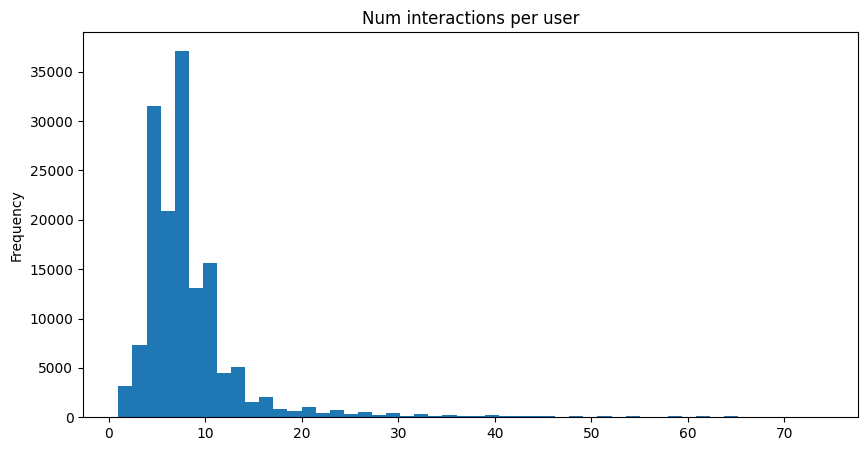

In [21]:
user_count = group_by_and_plot(df, group_by_name='user_id', rating_col_name='progress', quantile=0.99, title='Num interactions per user')

count    101885.000000
mean          2.800579
std          10.026988
min           1.000000
5%            1.000000
25%           1.000000
50%           1.000000
75%           2.000000
95%           5.000000
max         691.000000
Name: rating, dtype: float64


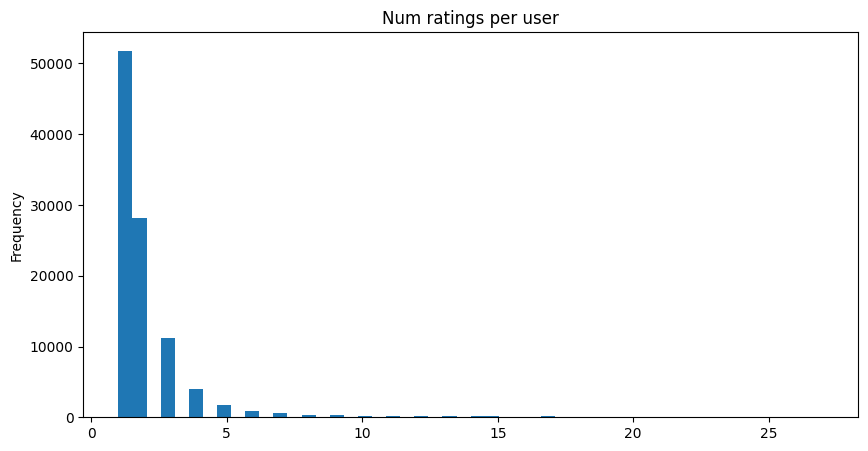

In [22]:
group_by_and_plot(df[~df['rating'].isna()], group_by_name='user_id', rating_col_name='rating', quantile=0.99, title='Num ratings per user');

count    59599.000000
mean        25.721875
std         60.665733
min          2.000000
5%           9.000000
25%         13.000000
50%         16.000000
75%         21.000000
95%         65.000000
max       6575.000000
Name: progress, dtype: float64


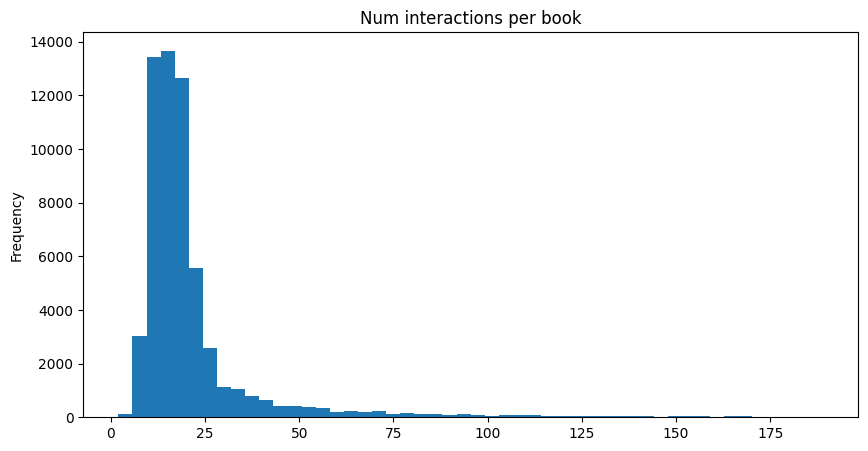

In [23]:
item_count = group_by_and_plot(df, group_by_name='item_id', rating_col_name='progress', quantile=0.99, title='Num interactions per book')

<a id='filter'></a>
# 0 Data filtering

What is a progress threshold for a relevant book?


### Laeving progress > 50

In [24]:
filtered_df = df[df['progress'] > 50]

In [25]:
get_log_info(filtered_df)

Num interactions = 712368,
num users = 143465,
num items = 59560


### Applying filter-5 strategy

1) books with num interactions >= 5

2) users with num interactions >= 5

In [26]:
item_counts = filtered_df.groupby('item_id')['user_id'].count()
pop_items = item_counts[item_counts > 4]
filtered_df = filtered_df[filtered_df['item_id'].isin(pop_items.index)]

In [27]:
user_counts = filtered_df.groupby('user_id')['item_id'].count()
pop_users = user_counts[user_counts > 4]
filtered_df = filtered_df[filtered_df['user_id'].isin(pop_users.index)].copy()

In [28]:
get_log_info(filtered_df)

Num interactions = 423599,
num users = 33875,
num items = 50982


In [29]:
assert filtered_df.shape[0] == 423599
assert filtered_df['user_id'].nunique() == 33875

### Id conversion / label encoding



In [30]:
%%time
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()
user_encoder.fit(filtered_df['user_id'])
item_encoder.fit(filtered_df['item_id'])

CPU times: user 90 ms, sys: 0 ns, total: 90 ms
Wall time: 106 ms


LabelEncoder()

In [31]:
i_features_filtered = i_features[i_features['item_id'].isin(filtered_df['item_id'].unique())].copy()
u_features_filtered = u_features[u_features['user_id'].isin(filtered_df['user_id'].unique())].copy()

In [32]:
%%time
filtered_df.loc[:, 'user_id'] = user_encoder.transform(filtered_df['user_id'])
filtered_df.loc[:, 'item_id'] = item_encoder.transform(filtered_df['item_id'])

CPU times: user 228 ms, sys: 0 ns, total: 228 ms
Wall time: 245 ms


In [33]:
%%time
i_features_filtered.loc[:, 'item_id'] = item_encoder.transform(i_features_filtered['item_id'])
u_features_filtered.loc[:, 'user_id'] = user_encoder.transform(u_features_filtered['user_id'])
# i_features_filtered.set_index('item_id', inplace=True)

CPU times: user 19.5 ms, sys: 0 ns, total: 19.5 ms
Wall time: 21 ms


In [34]:
TEST_BOOK = 36618
i_features_filtered[i_features_filtered['item_id'] == TEST_BOOK]

,item_id,title,genres,authors,year
43954,36618,Магический спецкурс. Первый семестр,"Попаданцы,Книги про волшебников,Любовное фэнтези",Лена Летняя,2017


In [35]:
TEST_USER = 4
u_features_filtered[u_features_filtered['user_id'] == TEST_USER]

,user_id,age,sex
19,4,18_24,0.0


# 1 Data split

What could be the problem in spliiting without timestamp considering?
Will use global time split + users and interactions filtering.

To consider: cross-validation



### Global time split: last 20% of data to test

In [36]:
train = filtered_df[filtered_df['start_date'] <= filtered_df['start_date'].quantile(0.8)]
test = filtered_df[filtered_df['start_date'] > filtered_df['start_date'].quantile(0.8)]

In [37]:
assert train.shape[0] == 339083
assert test.shape[0] == 84516

### take first 5 interactions in test

In [38]:
counts_in_test = test.groupby('user_id')['item_id'].count()
test = test[test['user_id'].isin(counts_in_test[counts_in_test > 4].index)].copy()
test['rank'] = test.groupby('user_id')['start_date'].rank(method="first", ascending=True)
test = test[test['rank'] <= 5].drop(columns=['rank'])

# remove cold users
test = test[test['user_id'].isin(train['user_id'].unique())]
test_users = test['user_id'].drop_duplicates()

In [39]:
assert test.shape[0] == 14995

In [40]:
get_log_info(train)

Num interactions = 339083,
num users = 33685,
num items = 49664


In [41]:
get_log_info(test)

Num interactions = 14995,
num users = 2999,
num items = 7635


More examples of splitting are available [here](https://github.com/sb-ai-lab/RePlay/blob/main/examples/04_splitters.ipynb)

## 2. Metrics

In [42]:
K = 10

#### HitRate

$$HitRate@K(i) = \max_{j \in [1..K]}\mathbb{1}_{r_{ij}}$$


$$ HitRate@K = \frac{\sum_{i=1}^{N}HitRate@K(i)}{N} $$

$\mathbb{1}_{r_{ij}}$ -- indicator function stating that user $i$ interacted with item $j$

In [43]:
def user_hr(row):
    """
    Calculate HitRate value.

    'row' contains
        a list of ground truth items in ``gt_items`` and
        a list of recommended items in ``pred_list``.
    """
    for item in row['pred_list']:
        if item in row['gt_list']:
            return 1
    return 0

#### Coverage

$$Coverage@K=\frac{\left|\bigcup\limits_{u\in U} y_u\right|}{|I|}$$


In [44]:
def coverage(pred, k, all_items):
    pred_to_consider = set(leave_top_k(pred, k)['item_id'].values)
    all_items = set(all_items.values)
    return len(pred_to_consider & all_items) / len(all_items)

#### Wrapping

In [45]:
def metric_wrap(pred, ground_truth, k, metric_by_user):
    """
    Prepare data for metric calculation (create dataframe with columns 'user_id', 'pred_list', 'gt_list').

    'pred_list' is a list of top-k recommendation ordered by relevance (most relevant is the first)
    'gt_list' is a list of items from tests data.
    Return mean metric value and dataframe with metric value for each user
    """
    pred_cropped = leave_top_k(pred, k)
    # prepare score lists
    pred_grouped = (pred_cropped
                .sort_values(['user_id', 'rating'], ascending=[False, False])
                .groupby('user_id')['item_id']
                .apply(list).rename('pred_list')
               )
    gt_grouped = ground_truth.groupby('user_id')['item_id'].apply(list).rename('gt_list')
    to_compare = gt_grouped.to_frame().join(pred_grouped, how='left')
    to_compare['pred_list'] = to_compare['pred_list'].apply(lambda x: x if isinstance(x, list) else [])
    # compute metric
    metric_by_user = to_compare.apply(metric_by_user, axis=1)
    return metric_by_user.mean(), metric_by_user

In [46]:
def leave_top_k(pred: pd.DataFrame,
                 k: int=K,
                 group_by_col: str='user_id',
                 order_by_col: str='rating') -> pd.DataFrame:
    """
    crop predictions to leave top-k recommendations for each user
    """
    if pred.groupby(group_by_col)[group_by_col].count().max() <= k:
        return pred
    cropped_pred = deepcopy(pred)
    cropped_pred['rank'] = (cropped_pred
                            .groupby(group_by_col)[[order_by_col]]
                            .rank(method="first", ascending=False))
    cropped_pred = cropped_pred[cropped_pred['rank'] <= k].drop(columns=['rank'])
    return cropped_pred

In [47]:
def measure(pred, true, name, metrics_hist=None, cov_items=None):
    if metrics_hist is None:
        metrics_hist = pd.DataFrame(columns=['hit_rate@K', 'coverage@K'])
    metrics_hist.loc[name, 'hit_rate@K'] = metric_wrap(pred=pred, ground_truth=true, k=K, metric_by_user=user_hr)[0]

    if cov_items is not None:
        metrics_hist.loc[name, 'coverage@K'] = coverage(pred=pred, k=K, all_items=cov_items)
    return metrics_hist

## 3. Baseline (most popular)

In [48]:
popular_items = train['item_id'].value_counts().head(10).index

In [49]:
users = []
items = []
ratings = []

for i, user in enumerate(test_users):
    users.extend([user] * 10)
    items.extend(popular_items)
    ratings.extend([1] * 10)

In [50]:
popular_preds = pd.DataFrame({'user_id': users, 'item_id': items, 'rating': ratings})

In [51]:
metrics = measure(popular_preds, test, 'PopRec', cov_items=train['item_id'].drop_duplicates())
metrics.sort_values('hit_rate@K', ascending=False)

,hit_rate@K,coverage@K
PopRec,0.023008,0.000201


## 4. SVD

# Truncated SVD

Let's use [svds](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.svds.html) from scipy.sparse.linalg. Absent ratings are imputed with zeros. Consider if the other approaches from today lecture better suit this dataset.

In [52]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

In [53]:
%%time
csr_train = csr_matrix((np.ones(train.shape[0]).astype(float), (train['user_id'], train['item_id'])))
user_vectors, singular_values, item_vectors = svds(A=csr_train, k=64)

CPU times: user 9.37 s, sys: 1.91 s, total: 11.3 s
Wall time: 6.72 s


In [54]:
user_vectors.shape, singular_values.shape, item_vectors.shape

((33875, 64), (64,), (64, 50982))

In [57]:
np.allclose(item_vectors @ item_vectors.T, np.eye(item_vectors.shape[0], item_vectors.shape[0]))

True

In [58]:
import matplotlib.pyplot as plt

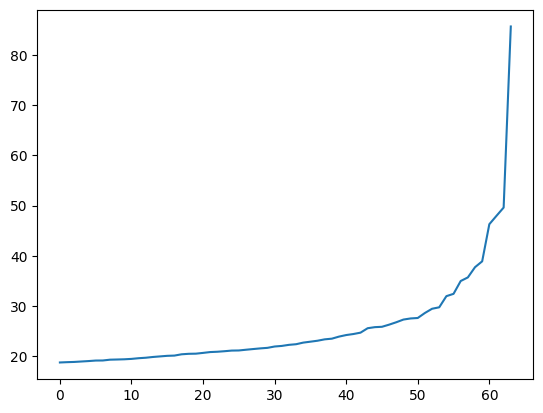

In [59]:
plt.plot(singular_values)

## Get top-10 personalized recommendations for user 4

In [60]:
u_features_filtered[u_features_filtered['user_id'] == TEST_USER]

,user_id,age,sex
19,4,18_24,0.0


In [61]:
train[train['user_id']== TEST_USER].merge(i_features_filtered, on='item_id').sort_values(by='start_date', ascending=False)

,user_id,item_id,progress,rating,start_date,title,genres,authors,year
15,4,1910,99,5.0,2019-08-28,Талорис,"Героическое фэнтези,Боевое фэнтези,Книги про в...",Алексей Пехов,2019
14,4,21713,100,5.0,2019-08-27,Синее пламя,"Героическое фэнтези,Боевое фэнтези,Книги про в...",Алексей Пехов,2015
13,4,41443,99,NaN,2019-08-25,Летос,"Героическое фэнтези,Боевое фэнтези",Алексей Пехов,2014
12,4,25988,100,NaN,2019-08-23,Вьюга теней,"Героическое фэнтези,Книги про волшебников",Алексей Пехов,2003
11,4,2121,97,NaN,2019-08-21,Джанга с тенями,"Героическое фэнтези,Боевое фэнтези",Алексей Пехов,2002
10,4,7220,97,NaN,2019-08-03,Крадущийся в тени,"Героическое фэнтези,Боевое фэнтези",Алексей Пехов,2001-2002
9,4,6225,96,NaN,2019-08-01,Проклятый горн,"Героическое фэнтези,Боевое фэнтези",Алексей Пехов,2014
8,4,19374,100,5.0,2019-07-29,Золотые костры,"Героическое фэнтези,Боевое фэнтези",Алексей Пехов,2012
7,4,33648,99,NaN,2019-07-24,Аутодафе,"Героическое фэнтези,Боевое фэнтези",Алексей Пехов,2011
6,4,11448,100,NaN,2019-07-23,Страж,"Героическое фэнтези,Книги про волшебников",Алексей Пехов,2010


In [62]:
rel = user_vectors[TEST_USER, :] @ np.diag(singular_values) @ item_vectors
ids = np.argpartition(rel, -K)[-K:]

In [63]:
res_pd = pd.DataFrame(list(zip(ids, rel[ids])), columns=['item_id', 'relevance']).merge(i_features_filtered[['item_id', 'title', 'authors', 'year', 'genres']], on='item_id')
res_pd.sort_values('relevance', ascending=False)

,item_id,relevance,title,authors,year,genres
7,21194,0.074483,Тень света,Андрей Васильев,2018,"Городское фэнтези,Книги про волшебников"
8,29766,0.069951,Разрушитель божественных замыслов,Владимир Сухинин,2017,"Героическое фэнтези,Попаданцы,Боевое фэнтези"
9,13963,0.065284,Пешка в большой игре,Владимир Сухинин,2017,"Героическое фэнтези,Попаданцы,Боевое фэнтези"
6,7330,0.064756,Вторая жизнь майора,Владимир Сухинин,2017,"Героическое фэнтези,Попаданцы,Боевое фэнтези"
4,39817,0.063497,Войны начинают неудачники,Вадим Панов,2003,"Героическое фэнтези,Боевое фэнтези,Городское ф..."
3,6225,0.063036,Проклятый горн,Алексей Пехов,2014,"Героическое фэнтези,Боевое фэнтези"
5,26414,0.062419,Великие Спящие. Том 1. Тьма против Тьмы,Виталий Зыков,2017,"Героическое фэнтези,Попаданцы,Боевое фэнтези"
2,26448,0.060571,Знаки ночи,Андрей Васильев,2018,"Городское фэнтези,Книги про волшебников"
1,43119,0.060058,Струны волшебства. Книга первая. Страшные сказ...,Милена Завойчинская,2018,"Героическое фэнтези,Книги про волшебников"
0,12710,0.059824,Командор войны,Вадим Панов,2003,"Героическое фэнтези,Боевое фэнтези,Городское ф..."


## SVD evaluation

In [64]:
%%time
scores2 = csr_train[test_users.values, :] @ item_vectors.T @ item_vectors

CPU times: user 50.8 s, sys: 564 ms, total: 51.4 s
Wall time: 52.7 s


In [65]:
%%time
scores = user_vectors[test_users.values, :] @ np.diag(singular_values) @ item_vectors

CPU times: user 47.3 s, sys: 651 ms, total: 48 s
Wall time: 48 s


In [66]:
%%time
np.allclose(scores2, scores)

CPU times: user 1.91 s, sys: 1.4 s, total: 3.32 s
Wall time: 3.63 s


True

In [67]:
%%time
scores = scores - csr_train[test_users.values, :] * 10**6
ids = np.argpartition(scores, -K)[: , -K:]

CPU times: user 2.62 s, sys: 1.93 s, total: 4.55 s
Wall time: 4.58 s


In [68]:
rec_scores = np.take_along_axis(scores, ids, axis=-1)

In [69]:
%%time
res = pd.DataFrame({"user_id": test_users.values,
                    "item_id": ids.tolist(),
                    "rating": rec_scores.tolist()})
svd_pred = res.explode(column=["item_id", "rating"])

CPU times: user 50.4 ms, sys: 2.86 ms, total: 53.3 ms
Wall time: 64.3 ms


In [70]:
%%time
metrics = measure(svd_pred, test, 'svd_rec', metrics, cov_items=train['item_id'].drop_duplicates())

CPU times: user 412 ms, sys: 9.23 ms, total: 422 ms
Wall time: 440 ms


In [71]:
metrics.sort_values('hit_rate@K', ascending=False)

,hit_rate@K,coverage@K
svd_rec,0.112704,0.030002
PopRec,0.023008,0.000201


## item2item

[distance measures in data science](https://towardsdatascience.com/9-distance-measures-in-data-science-918109d069fa)


In [72]:
i_features_filtered[i_features_filtered['item_id'] == TEST_BOOK]

,item_id,title,genres,authors,year
43954,36618,Магический спецкурс. Первый семестр,"Попаданцы,Книги про волшебников,Любовное фэнтези",Лена Летняя,2017


In [73]:
popularity = train.groupby('item_id')['user_id'].count().rename('popularity').sort_values(ascending=False)
items_with_pop = i_features_filtered.merge(popularity, right_index=True, left_on="item_id")

In [74]:
items_with_pop.sort_values("popularity", ascending=False).head()

,item_id,title,genres,authors,year,popularity
15077,14267,Зулейха открывает глаза,Современная русская литература,Гузель Яхина,2015,571
13860,50597,Черновик,Научная фантастика,Сергей Лукьяненко,2004-05,490
21079,19385,Снеговик,"Зарубежные детективы,Триллеры,Полицейские дете...",Ю Несбё,2007,459
21704,42084,После,"Зарубежные любовные романы,Современные любовны...",Анна Тодд,2014,459
34174,39972,Земное притяжение,"Современные детективы,Остросюжетные любовные р...",Татьяна Устинова,2017,382


In [75]:
items_with_pop[items_with_pop['item_id'] == TEST_BOOK]

,item_id,title,genres,authors,year,popularity
43954,36618,Магический спецкурс. Первый семестр,"Попаданцы,Книги про волшебников,Любовное фэнтези",Лена Летняя,2017,239


### cosine similarity

In [76]:
from sklearn.metrics.pairwise import cosine_similarity

In [77]:
rel = cosine_similarity(item_vectors.T[[TEST_BOOK], :], item_vectors.T).ravel()
ids = np.argpartition(rel, -K)[-K:]
pd.DataFrame(list(zip(ids, rel[ids])), columns=['item_id', 'relevance']).merge(items_with_pop, on='item_id').sort_values('relevance', ascending=False)

,item_id,relevance,title,genres,authors,year,popularity
7,36618,1.000000,Магический спецкурс. Первый семестр,"Попаданцы,Книги про волшебников,Любовное фэнтези",Лена Летняя,2017,239
8,36999,0.990003,Магический спецкурс. Второй семестр,"Любовно-фантастические романы,Попаданцы,Любовн...",Лена Летняя,2018,219
5,8806,0.960270,Сочинения Александра Пушкина. Статья третья,"Литература 19 века,Критика",Виссарион Белинский,1843,4
9,2191,0.959478,Пищеблок,"Мистика,Современная русская литература",Алексей Иванов,2018,1
6,31117,0.956306,Чёрная кошка,"Книги для подростков,Книги для дошкольников",Александр Кувшинов,2018,2
4,34393,0.956139,Проект «Изоляция»,Боевая фантастика,Кирилл Шарапов,2013,1
2,12147,0.955719,Психотерапия и магия коррекции веса,"Похудение и диеты,Практическая психология,Псих...",Борис Акимов,2017,3
3,9139,0.955111,Врата Победы: Ленинград-43. Сумерки богов. Вра...,"Историческая фантастика,Попаданцы",Владислав Савин,2019,2
1,18880,0.953830,Ты самая любимая (сборник),Современная русская литература,Эдуард Тополь,2011,3
0,10944,0.950389,Вeрните моего сына,"Современные детективы,Остросюжетные любовные р...",Анна Исламова,2019,3


In [78]:
# low-popularity corresponds to low norm (31117, "Чёрная кошка")
np.linalg.norm(item_vectors.T[TEST_BOOK]), np.linalg.norm(item_vectors.T[31117]),

(0.4816126391613593, 0.0024922140178370044)

In [79]:
# one of "Чёрная кошка" readers also read "Магический спецкурс. Первый семестр"
train[train['user_id'].isin(train[train['item_id'] == 31117]['user_id'])].sort_values("user_id")

,user_id,item_id,progress,rating,start_date
43486,1641,41952,80,4.0,2018-01-22
113144,1641,14723,80,NaN,2018-02-23
210588,1641,31117,74,NaN,2018-04-12
401808,1641,1079,73,NaN,2018-07-13
29911,4371,36569,69,NaN,2018-01-15
298700,4371,9139,63,NaN,2018-05-25
848074,4371,34393,72,NaN,2019-02-10
930736,4371,47681,89,NaN,2019-03-21
943232,4371,36618,100,NaN,2019-03-27
961497,4371,36999,100,NaN,2019-04-05


### cosine similarity for popular

In [80]:
popular = items_with_pop[items_with_pop['popularity'] > 30].item_id.values
popular.shape

(1968,)

In [81]:
rel = cosine_similarity(item_vectors.T[[TEST_BOOK], :], item_vectors.T[popular]).ravel()
ids = np.argpartition(rel, -K)[-K:]
pd.DataFrame(list(zip(popular[ids], rel[ids])), columns=['item_id', 'relevance']).merge(items_with_pop, on='item_id').sort_values('relevance', ascending=False)

,item_id,relevance,title,genres,authors,year,popularity
2,36618,1.000000,Магический спецкурс. Первый семестр,"Попаданцы,Книги про волшебников,Любовное фэнтези",Лена Летняя,2017,239
3,36999,0.990003,Магический спецкурс. Второй семестр,"Любовно-фантастические романы,Попаданцы,Любовн...",Лена Летняя,2018,219
6,3554,0.930311,Проклятый ректор,"Детективное фэнтези,Книги про волшебников,Любо...",Лена Летняя,2017,190
9,8352,0.901418,Академия Легиона,"Детективное фэнтези,Книги о приключениях,Любов...",Лена Летняя,2018,127
4,12465,0.782747,Невеста Смерти,"Детективное фэнтези,Любовное фэнтези",Лена Летняя,2018,304
7,20401,0.468093,Монстр,"Детективное фэнтези,Любовное фэнтези","Елена Обухова,Лена Летняя",2018,42
8,41402,0.275664,Попаданка и король,"Любовно-фантастические романы,Остросюжетные лю...",Матильда Старр,2018,51
5,36281,0.264708,Только ты,Современные любовные романы,Янина Логвин,2018,91
1,39858,0.259347,Награда для генерала. Книга первая: шепот ветра,Любовное фэнтези,Лена Летняя,2019,31
0,34241,0.239656,Хранительница времени. Выбор,"Любовно-фантастические романы,Попаданцы,Любовн...",Алена Федотовская,2015,54


### dot product

In [82]:
rel = (item_vectors.T[[TEST_BOOK], :] @ item_vectors).ravel()
ids = np.argpartition(rel, -K)[-K:]
pd.DataFrame(list(zip(ids, rel[ids])), columns=['item_id', 'relevance']).merge(items_with_pop, on='item_id').sort_values('relevance', ascending=False)


,item_id,relevance,title,genres,authors,year,popularity
9,36618,0.231951,Магический спецкурс. Первый семестр,"Попаданцы,Книги про волшебников,Любовное фэнтези",Лена Летняя,2017,239
8,36999,0.229213,Магический спецкурс. Второй семестр,"Любовно-фантастические романы,Попаданцы,Любовн...",Лена Летняя,2018,219
7,3554,0.172281,Проклятый ректор,"Детективное фэнтези,Книги про волшебников,Любо...",Лена Летняя,2017,190
6,12465,0.147804,Невеста Смерти,"Детективное фэнтези,Любовное фэнтези",Лена Летняя,2018,304
3,8352,0.138050,Академия Легиона,"Детективное фэнтези,Книги о приключениях,Любов...",Лена Летняя,2018,127
4,33943,0.030594,Опасно быть студентом,"Детективное фэнтези,Любовное фэнтези,Юмористич...",Маргарита Блинова,2015,156
5,43119,0.025599,Струны волшебства. Книга первая. Страшные сказ...,"Героическое фэнтези,Книги про волшебников",Милена Завойчинская,2018,306
2,29524,0.022279,Забавно быть студентом,"Героическое фэнтези,Книги про волшебников,Маги...",Маргарита Блинова,2016,119
1,20401,0.021734,Монстр,"Детективное фэнтези,Любовное фэнтези","Елена Обухова,Лена Летняя",2018,42
0,1838,0.020996,Алая печать. Академия Сиятельных,"Героическое фэнтези,Книги про волшебников,Любо...",Настя Любимка,2016,180
